# Google Play Store Project

### This project ....


### 1) Import the libraries we are going to need for the project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objs as go
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, precision_score, recall_score, f1_score
from scipy.stats import pearsonr
from scipy import stats


### 2) Import the information from the CSV files

In [2]:
df = pd.read_csv('googleplaystore.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


As we can see, there are some missing values in the dataset, specially in the 'Rating' category. We have multiples options to deal with this situation:

1) Replace the empty space with the mean (in case it is a numerical value)

2) Replace the empty space with the most frequent value

3) Replace the empty space with the mean of the category that it belongs to

4) Just eliminate those rows.

In [3]:
print(df['Rating'].unique())
print(df['Rating'].value_counts())

[ 4.1  3.9  4.7  4.5  4.3  4.4  3.8  4.2  4.6  3.2  4.   nan  4.8  4.9
  3.6  3.7  3.3  3.4  3.5  3.1  5.   2.6  3.   1.9  2.5  2.8  2.7  1.
  2.9  2.3  2.2  1.7  2.   1.8  2.4  1.6  2.1  1.4  1.5  1.2 19. ]
4.4     1109
4.3     1076
4.5     1038
4.2      952
4.6      823
4.1      708
4.0      568
4.7      499
3.9      386
3.8      303
5.0      274
3.7      239
4.8      234
3.6      174
3.5      163
3.4      128
3.3      102
4.9       87
3.0       83
3.1       69
3.2       64
2.9       45
2.8       42
2.7       25
2.6       25
2.5       21
2.3       20
2.4       19
1.0       16
2.2       14
1.9       13
2.0       12
1.7        8
1.8        8
2.1        8
1.6        4
1.4        3
1.5        3
1.2        1
19.0       1
Name: Rating, dtype: int64


In the 'Rating' we found a value equal to 19, but the range should be between 1.0 and 5.0. One option is to assume that the customer wanted to write '1.9', and change it ourselves, or just eliminate that column.

In [4]:
df[df['Rating'] == 19]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


We can see that what happened is that the data is not in the right possition, it should be one space to the right.

In [5]:
df.iloc[10472,:]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                               19.0
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [6]:
df.iloc[10472,1:]=df.iloc[10472,1:].shift(1)
df.iloc[10472,:]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                             None
Rating                                                1.9
Reviews                                              19.0
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                                NaN
Last Updated                            February 11, 2018
Current Ver                                        1.0.19
Android Ver                                    4.0 and up
Name: 10472, dtype: object

Since we don't know the category, we are leaving that plae as a missing value.
On the other hand, the dtype of the category 'Last Updated' is object, when it should be a date. In consecuence, we have to change it.

In [7]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

### 3) Data Analysis

We have multiples categories to analyze, however, a good place to start is with the category 'Type' since it is a binary, paid of not paid. We know that we have 1 missing value so in this case we are just going to ignore that column.

In [8]:
df.dropna(subset = 'Type', inplace = True)

In [9]:
df['Type'].info()

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: Type
Non-Null Count  Dtype 
--------------  ----- 
10840 non-null  object
dtypes: object(1)
memory usage: 169.4+ KB


Now we only have 10.840 rows in the dataframe, and 0 null values for the column 'Type'

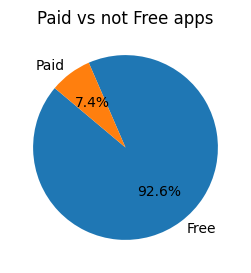

In [10]:
type_counts = df['Type'].value_counts()

plt.figure(figsize=(4, 3)) 
plt.pie(type_counts, labels = type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Paid vs not Free apps')

plt.show()

Since we want to see the behaviour of the customers, we need to condense the different dates into just months and years. To do that, we are adding 2 extra columns.

In [11]:
df['Year_Last_Updated'] = df['Last Updated'].dt.year
df['Month_Last_Updated'] = df['Last Updated'].dt.month

In [12]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Year_Last_Updated,Month_Last_Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,2018,1
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,2018,1
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,2018,8
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,2018,6
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,2018,6


In [13]:
df_free = df[df['Type'] == 'Free']
df_paid = df[df['Type'] == 'Paid']

In [14]:

table_year = pd.crosstab(df['Year_Last_Updated'], df['Type'])
table_sorted = table_year.sort_index(ascending=False)
print(table_sorted)

Type               Free  Paid
Year_Last_Updated            
2018               7004   345
2017               1684   183
2016                710    94
2015                377    82
2014                150    59
2013                 81    29
2012                 21     5
2011                 12     3
2010                  1     0


<Figure size 1000x600 with 0 Axes>

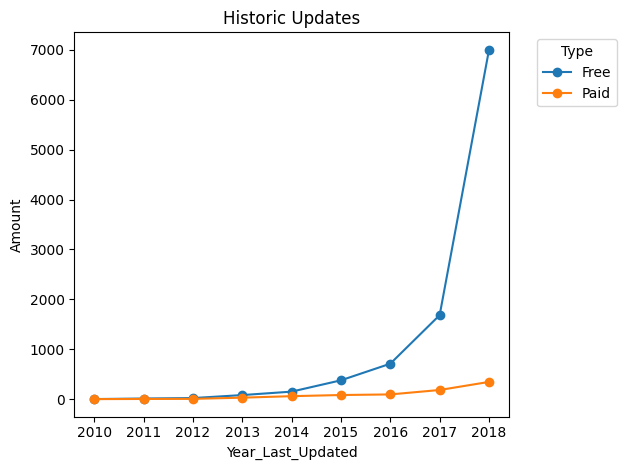

In [15]:
plt.figure(figsize=(10, 6)) 
table_sorted.plot(kind='line', marker='o')
plt.title('Historic Updates')
plt.xlabel('Year_Last_Updated')
plt.ylabel('Amount')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Ubicación de la leyenda fuera del gráfico
plt.tight_layout()  # Ajustar el diseño para que la leyenda no se corte
plt.show()

In [16]:
table_month = pd.crosstab(df['Month_Last_Updated'], df['Type'])
table_sorted_2 = table_month.sort_index(ascending=True)
print(table_sorted_2)

Type                Free  Paid
Month_Last_Updated            
1                    444    47
2                    489    45
3                    595    72
4                    553    63
5                    897    81
6                   1179    93
7                   3022   141
8                   1511    83
9                    283    31
10                   357    41
11                   347    40
12                   363    63


<Figure size 1000x600 with 0 Axes>

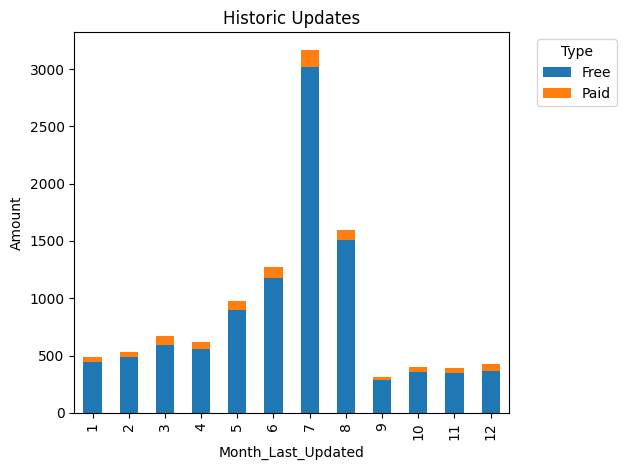

In [17]:
plt.figure(figsize=(10, 6)) 
table_sorted_2.plot(kind='bar', stacked= True)
plt.title('Historic Updates')
plt.xlabel('Month_Last_Updated')
plt.ylabel('Amount')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Now let's see only for Paid apps, since it is difficult to see in this graphic

In [18]:
table_month_paid = pd.crosstab(df_paid['Month_Last_Updated'], df_paid['Type'])
table_sorted_3 = table_month_paid.sort_index(ascending=True)
print(table_sorted_3)

Type                Paid
Month_Last_Updated      
1                     47
2                     45
3                     72
4                     63
5                     81
6                     93
7                    141
8                     83
9                     31
10                    41
11                    40
12                    63


<Figure size 1000x600 with 0 Axes>

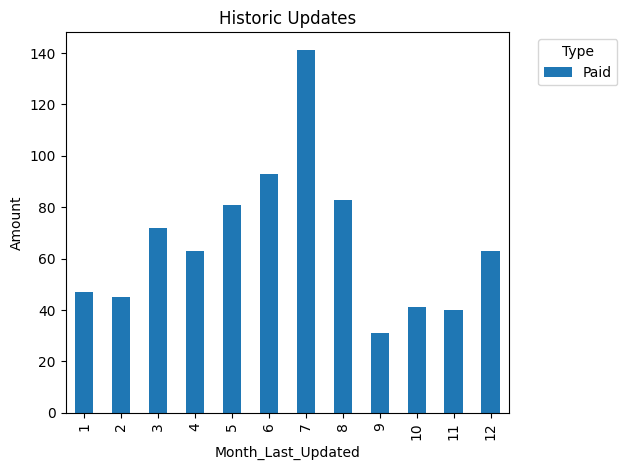

In [19]:
plt.figure(figsize=(10, 6)) 
table_sorted_3.plot(kind='bar', stacked= True)
plt.title('Historic Updates')
plt.xlabel('Month_Last_Updated')
plt.ylabel('Amount')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Ubicación de la leyenda fuera del gráfico
plt.tight_layout()  # Ajustar el diseño para que la leyenda no se corte
plt.show()

Now we are going to check what kind of public are the apps aming for, it means the type of contect.

In [20]:
print(df['Content Rating'].info())

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: Content Rating
Non-Null Count  Dtype 
--------------  ----- 
10840 non-null  object
dtypes: object(1)
memory usage: 169.4+ KB
None


There are no null objects so we can continue with our analysis.

In [21]:
content = df['Content Rating'].value_counts().reset_index()
content.columns = ['Content', 'Total_Count']
print(content)

           Content  Total_Count
0         Everyone         8715
1             Teen         1208
2       Mature 17+          499
3     Everyone 10+          413
4  Adults only 18+            3
5          Unrated            2


As we can see, most of the apps have a type of content that can be consumed by everyone. Now let's divide them into different types of payment.

In [22]:
table_content_payment = pd.crosstab(df['Content Rating'], df['Type']).sort_values(by = ['Free', 'Paid'], ascending = False)
print(table_content_payment)

Type             Free  Paid
Content Rating             
Everyone         8020   695
Teen             1156    52
Mature 17+        479    20
Everyone 10+      380    33
Adults only 18+     3     0
Unrated             2     0


For both types of payments, the contect for everyone is dominant.
On the other hand, something really importat is to identify how people rate the different apps.

In [23]:
print(df['Rating'].info())

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: Rating
Non-Null Count  Dtype 
--------------  ----- 
9367 non-null   object
dtypes: object(1)
memory usage: 169.4+ KB
None


We have a lot of null values, so we are creating a copy of the original dataframe we are gong to eliminate every null value. We create a copy instead of modifing the original df because those same rows contain a lot of important information that can helps us in the future.

In [24]:
df_rating = df.dropna(subset = 'Rating', inplace = False)
print(df_rating.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9367 entries, 0 to 10840
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 9367 non-null   object        
 1   Category            9366 non-null   object        
 2   Rating              9367 non-null   object        
 3   Reviews             9367 non-null   object        
 4   Size                9367 non-null   object        
 5   Installs            9367 non-null   object        
 6   Type                9367 non-null   object        
 7   Price               9367 non-null   object        
 8   Content Rating      9367 non-null   object        
 9   Genres              9366 non-null   object        
 10  Last Updated        9367 non-null   datetime64[ns]
 11  Current Ver         9363 non-null   object        
 12  Android Ver         9365 non-null   object        
 13  Year_Last_Updated   9367 non-null   int64      

In [25]:
df_rating.reset_index(drop = True, inplace = True)
print(df_rating.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9367 entries, 0 to 9366
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 9367 non-null   object        
 1   Category            9366 non-null   object        
 2   Rating              9367 non-null   object        
 3   Reviews             9367 non-null   object        
 4   Size                9367 non-null   object        
 5   Installs            9367 non-null   object        
 6   Type                9367 non-null   object        
 7   Price               9367 non-null   object        
 8   Content Rating      9367 non-null   object        
 9   Genres              9366 non-null   object        
 10  Last Updated        9367 non-null   datetime64[ns]
 11  Current Ver         9363 non-null   object        
 12  Android Ver         9365 non-null   object        
 13  Year_Last_Updated   9367 non-null   int64       

In [26]:
df_rating['Rating'] = df_rating['Rating'].astype(float)
table_rating_payment = pd.crosstab(df_rating['Rating'], df_rating['Type'])
print(table_rating_payment)

Type    Free  Paid
Rating            
1.0       14     2
1.2        1     0
1.4        3     0
1.5        3     0
1.6        4     0
1.7        7     1
1.8        7     1
1.9       14     0
2.0       11     1
2.1        8     0
2.2       14     0
2.3       18     2
2.4       17     2
2.5       20     1
2.6       23     2
2.7       23     2
2.8       39     3
2.9       40     5
3.0       75     8
3.1       65     4
3.2       62     2
3.3       97     5
3.4      117    11
3.5      152    11
3.6      164    10
3.7      228    11
3.8      282    21
3.9      370    16
4.0      546    22
4.1      676    32
4.2      890    62
4.3     1025    51
4.4     1031    78
4.5      965    73
4.6      741    82
4.7      446    53
4.8      195    39
4.9       81     6
5.0      246    28


C:\Users\user\AppData\Local\Temp\ipykernel_20900\2268151734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rating['Rating'] = df_rating['Rating'].astype(float)


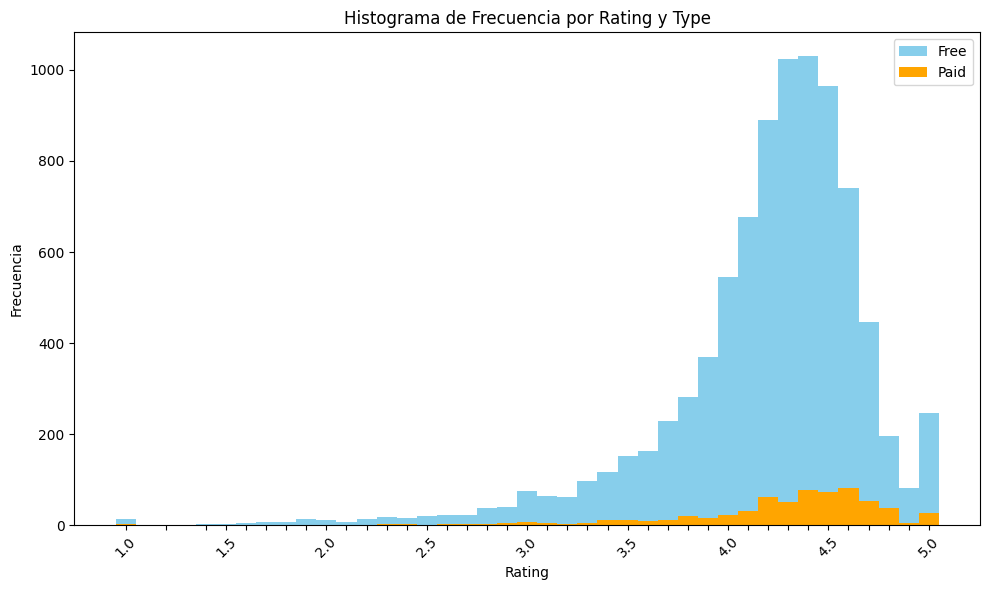

In [27]:
frequency_free = table_rating_payment['Free']
frequency_paid = table_rating_payment['Paid']

plt.figure(figsize=(10, 6))

x_values = table_rating_payment.index
x_labels = [str(value) if value % 0.5 == 0 else '' for value in x_values]

plt.bar(x_values - 0, frequency_free, width=0.1, label='Free', color='skyblue')
plt.bar(x_values - 0, frequency_paid, width=0.1, label='Paid', color='orange')

plt.title('Histograma de Frecuencia por Rating y Type')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.xticks(x_values, x_labels, rotation=45) 
plt.legend()
plt.tight_layout()
plt.show()

So far we can see that most of the apps that are dowloaded are rated around 4.3. Let's go with the other characteristics, this part is going to be a little bit faster.

In [28]:
table_category_payment = pd.crosstab(df['Category'], df['Type']).sort_values(by = ['Free', 'Paid'], ascending = False)
print(table_category_payment)

Type                 Free  Paid
Category                       
FAMILY               1780   191
GAME                 1061    83
TOOLS                 765    78
BUSINESS              446    14
PRODUCTIVITY          396    28
LIFESTYLE             363    19
COMMUNICATION         360    27
SPORTS                360    24
MEDICAL               354   109
FINANCE               349    17
HEALTH_AND_FITNESS    325    16
PHOTOGRAPHY           313    22
PERSONALIZATION       309    83
SOCIAL                292     3
NEWS_AND_MAGAZINES    281     2
SHOPPING              258     2
TRAVEL_AND_LOCAL      246    12
DATING                227     7
BOOKS_AND_REFERENCE   203    28
VIDEO_PLAYERS         171     4
EDUCATION             152     4
ENTERTAINMENT         147     2
MAPS_AND_NAVIGATION   132     5
FOOD_AND_DRINK        125     2
HOUSE_AND_HOME         88     0
LIBRARIES_AND_DEMO     84     1
AUTO_AND_VEHICLES      82     3
WEATHER                74     8
EVENTS                 63     1
ART_AND_

In [29]:
table_version_payment = pd.crosstab(df['Android Ver'], df['Type']).sort_values(by = ['Android Ver'], ascending = False)
#table_version_payment = pd.crosstab(df['Android Ver'], df['Type']).sort_values(by = ['Free', 'Paid'], ascending = False)

print(table_version_payment)

Type                Free  Paid
Android Ver                   
Varies with device  1295    66
8.0 and up             5     1
7.1 and up             3     0
7.0 and up            29    13
7.0 - 7.1.1            1     0
6.0 and up            55     5
5.1 and up            21     3
5.0 and up           569    32
5.0 - 8.0              2     0
5.0 - 7.1.1            1     0
5.0 - 6.0              1     0
4.4W and up            9     3
4.4 and up           939    41
4.3 and up           229    14
4.2 and up           373    21
4.1 and up          2320   131
4.1 - 7.1.1            1     0
4.0.3 and up        1412    89
4.0.3 - 7.1.1          2     0
4.0 and up          1273   103
3.2 and up            28     8
3.1 and up             9     1
3.0 and up           207    34
2.3.3 and up         251    30
2.3 and up           580    72
2.2 and up           195    49
2.2 - 7.1.1            1     0
2.1 and up           107    27
2.0.1 and up           2     5
2.0 and up            26     6
1.6 and 

In [30]:
table_installs_payment = pd.crosstab(df['Installs'], df['Type']).sort_values(by = ['Free', 'Paid'], ascending = False)

print(table_installs_payment)

Type            Free  Paid
Installs                  
1,000,000+      1555    24
10,000,000+     1249     3
100,000+        1079    90
10,000+          925   129
1,000+           759   149
5,000,000+       752     0
100+             623    96
500,000+         527    12
50,000+          436    43
5,000+           410    67
100,000,000+     409     0
10+              316    70
500+             290    40
50,000,000+      289     0
50+              171    34
500,000,000+      72     0
5+                70    12
1,000,000,000+    58     0
1+                46    21
0+                 4    10


In [31]:
print(df['Installs'].info())

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: Installs
Non-Null Count  Dtype 
--------------  ----- 
10840 non-null  object
dtypes: object(1)
memory usage: 169.4+ KB
None


In [32]:
df['Installs'] = df['Installs'].str.replace('+','')
df['Installs'] = df['Installs'].str.replace(',','').astype(int)

C:\Users\user\AppData\Local\Temp\ipykernel_20900\3550140803.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Installs'] = df['Installs'].str.replace('+','')


In [33]:
print(df['Installs'].info())
print(df['Installs'].unique())

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: Installs
Non-Null Count  Dtype
--------------  -----
10840 non-null  int32
dtypes: int32(1)
memory usage: 127.0 KB
None
[     10000     500000    5000000   50000000     100000      50000
    1000000   10000000       5000  100000000 1000000000       1000
  500000000         50        100        500         10          1
          5          0]


The price is an important characteristic that we have to pay attention to. First we need to check for null values, and then change the type from 'str' to 'float'

In [34]:
print(df['Price'].info())
print(df['Price'].unique())


<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: Price
Non-Null Count  Dtype 
--------------  ----- 
10840 non-null  object
dtypes: object(1)
memory usage: 169.4+ KB
None
['0' '$4.99' '$3.99' '$6.99' '$1.49' '$2.99' '$7.99' '$5.99' '$3.49'
 '$1.99' '$9.99' '$7.49' '$0.99' '$9.00' '$5.49' '$10.00' '$24.99'
 '$11.99' '$79.99' '$16.99' '$14.99' '$1.00' '$29.99' '$12.99' '$2.49'
 '$10.99' '$1.50' '$19.99' '$15.99' '$33.99' '$74.99' '$39.99' '$3.95'
 '$4.49' '$1.70' '$8.99' '$2.00' '$3.88' '$25.99' '$399.99' '$17.99'
 '$400.00' '$3.02' '$1.76' '$4.84' '$4.77' '$1.61' '$2.50' '$1.59' '$6.49'
 '$1.29' '$5.00' '$13.99' '$299.99' '$379.99' '$37.99' '$18.99' '$389.99'
 '$19.90' '$8.49' '$1.75' '$14.00' '$4.85' '$46.99' '$109.99' '$154.99'
 '$3.08' '$2.59' '$4.80' '$1.96' '$19.40' '$3.90' '$4.59' '$15.46' '$3.04'
 '$4.29' '$2.60' '$3.28' '$4.60' '$28.99' '$2.95' '$2.90' '$1.97'
 '$200.00' '$89.99' '$2.56' '$30.99' '$3.61' '$394.99' '$1.26' '$1.20'
 '$1.04']


In [35]:
df['Price'] = df['Price'].str.replace('$','')
df['Price'] = df['Price'].str.replace(',','').astype(float)


C:\Users\user\AppData\Local\Temp\ipykernel_20900\1648563860.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Price'] = df['Price'].str.replace('$','')


In [36]:
print(df['Price'].info())
print(df['Price'].unique())

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
10840 non-null  float64
dtypes: float64(1)
memory usage: 169.4 KB
None
[  0.     4.99   3.99   6.99   1.49   2.99   7.99   5.99   3.49   1.99
   9.99   7.49   0.99   9.     5.49  10.    24.99  11.99  79.99  16.99
  14.99   1.    29.99  12.99   2.49  10.99   1.5   19.99  15.99  33.99
  74.99  39.99   3.95   4.49   1.7    8.99   2.     3.88  25.99 399.99
  17.99 400.     3.02   1.76   4.84   4.77   1.61   2.5    1.59   6.49
   1.29   5.    13.99 299.99 379.99  37.99  18.99 389.99  19.9    8.49
   1.75  14.     4.85  46.99 109.99 154.99   3.08   2.59   4.8    1.96
  19.4    3.9    4.59  15.46   3.04   4.29   2.6    3.28   4.6   28.99
   2.95   2.9    1.97 200.    89.99   2.56  30.99   3.61 394.99   1.26
   1.2    1.04]


Now let's adjust the size

In [37]:
print(df['Size'].info())
print(df['Size'].unique())

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: Size
Non-Null Count  Dtype 
--------------  ----- 
10840 non-null  object
dtypes: object(1)
memory usage: 169.4+ KB
None
['19M' '14M' '8.7M' '25M' '2.8M' '5.6M' '29M' '33M' '3.1M' '28M' '12M'
 '20M' '21M' '37M' '2.7M' '5.5M' '17M' '39M' '31M' '4.2M' '7.0M' '23M'
 '6.0M' '6.1M' '4.6M' '9.2M' '5.2M' '11M' '24M' 'Varies with device'
 '9.4M' '15M' '10M' '1.2M' '26M' '8.0M' '7.9M' '56M' '57M' '35M' '54M'
 '201k' '3.6M' '5.7M' '8.6M' '2.4M' '27M' '2.5M' '16M' '3.4M' '8.9M'
 '3.9M' '2.9M' '38M' '32M' '5.4M' '18M' '1.1M' '2.2M' '4.5M' '9.8M' '52M'
 '9.0M' '6.7M' '30M' '2.6M' '7.1M' '3.7M' '22M' '7.4M' '6.4M' '3.2M'
 '8.2M' '9.9M' '4.9M' '9.5M' '5.0M' '5.9M' '13M' '73M' '6.8M' '3.5M'
 '4.0M' '2.3M' '7.2M' '2.1M' '42M' '7.3M' '9.1M' '55M' '23k' '6.5M' '1.5M'
 '7.5M' '51M' '41M' '48M' '8.5M' '46M' '8.3M' '4.3M' '4.7M' '3.3M' '40M'
 '7.8M' '8.8M' '6.6M' '5.1M' '61M' '66M' '79k' '8.4M' '118k' '44M' '695k'
 '1.6M'

In [38]:
print(df['Size'].value_counts()['Varies with device'])

1694


So we have the problema that 'Varies with device' is found almost 1700 times in our dataframe, so we can:
1) Eliminate those rows
2) Replace with the mean
3) Relace with the median
4) Replace with the mode
5) Other option

In this case we are replacing with the median. Therefore we need a copy.

In [39]:
df_size = df.loc[df['Size'] != 'Varies with device'].copy()
df_size.reset_index(drop = True, inplace = True)
print(df_size.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9146 entries, 0 to 9145
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 9146 non-null   object        
 1   Category            9145 non-null   object        
 2   Rating              7730 non-null   object        
 3   Reviews             9146 non-null   object        
 4   Size                9146 non-null   object        
 5   Installs            9146 non-null   int32         
 6   Type                9146 non-null   object        
 7   Price               9146 non-null   float64       
 8   Content Rating      9146 non-null   object        
 9   Genres              9145 non-null   object        
 10  Last Updated        9146 non-null   datetime64[ns]
 11  Current Ver         9138 non-null   object        
 12  Android Ver         9144 non-null   object        
 13  Year_Last_Updated   9146 non-null   int64       

In [40]:
def convert_size(size_str):
    if 'M' in size_str:
        return float(size_str.replace('M', ''))
    elif 'k' in size_str:
        return float(size_str.replace('k', '')) / 1024 

In [41]:

df_size['Size'] = df_size['Size'].apply(convert_size)

In [42]:
print(df_size['Size'])

0       19.0
1       14.0
2        8.7
3       25.0
4        2.8
        ... 
9141     9.6
9142    53.0
9143     3.6
9144     9.5
9145    19.0
Name: Size, Length: 9146, dtype: float64


In [43]:
df_size['Size'].median()

13.0

So we know that the median is 13, therefore every time we see a value that can't be converted into a float number, we are replacing it by 13 MB 

In [44]:
df['Size'].replace('Varies with device', '13M', inplace = True)

In [45]:
df['Size'] = df['Size'].apply(convert_size)

In [46]:
print(df['Size'].info())
print(df['Size'].unique())

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: Size
Non-Null Count  Dtype  
--------------  -----  
10840 non-null  float64
dtypes: float64(1)
memory usage: 169.4 KB
None
[1.90000000e+01 1.40000000e+01 8.70000000e+00 2.50000000e+01
 2.80000000e+00 5.60000000e+00 2.90000000e+01 3.30000000e+01
 3.10000000e+00 2.80000000e+01 1.20000000e+01 2.00000000e+01
 2.10000000e+01 3.70000000e+01 2.70000000e+00 5.50000000e+00
 1.70000000e+01 3.90000000e+01 3.10000000e+01 4.20000000e+00
 7.00000000e+00 2.30000000e+01 6.00000000e+00 6.10000000e+00
 4.60000000e+00 9.20000000e+00 5.20000000e+00 1.10000000e+01
 2.40000000e+01 1.30000000e+01 9.40000000e+00 1.50000000e+01
 1.00000000e+01 1.20000000e+00 2.60000000e+01 8.00000000e+00
 7.90000000e+00 5.60000000e+01 5.70000000e+01 3.50000000e+01
 5.40000000e+01 1.96289062e-01 3.60000000e+00 5.70000000e+00
 8.60000000e+00 2.40000000e+00 2.70000000e+01 2.50000000e+00
 1.60000000e+01 3.40000000e+00 8.90000000e+00 3.90000000e

Now we are going to fit the data in order to be used by a regresion model. This time we are going to focus in the numerical information,  so it is going to be a simple analysis. If we want to take into account no numerical data, we can use one of the next methods.

1) One-Hot Encoding
2) Label Encoding
3) Cardinal Coding
4) Frequency coding
5) Embendding  (in case of neural networks)
6) Any other one

We also have to adjust the type of the categories that we didn't before.

In [47]:
df['Rating'] = df['Rating'].astype(float)
df['Reviews'] = df['Reviews'].astype(int)

In [48]:
df_regresion = df.dropna()
key_features = ['Reviews','Size','Installs','Price']
objective_feature = ['Rating']
x = df_regresion[key_features]
y = df_regresion[objective_feature]

In [49]:
df_regresion.info()
df_regresion.head(4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 9360 non-null   object        
 1   Category            9360 non-null   object        
 2   Rating              9360 non-null   float64       
 3   Reviews             9360 non-null   int32         
 4   Size                9360 non-null   float64       
 5   Installs            9360 non-null   int32         
 6   Type                9360 non-null   object        
 7   Price               9360 non-null   float64       
 8   Content Rating      9360 non-null   object        
 9   Genres              9360 non-null   object        
 10  Last Updated        9360 non-null   datetime64[ns]
 11  Current Ver         9360 non-null   object        
 12  Android Ver         9360 non-null   object        
 13  Year_Last_Updated   9360 non-null   int64      

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Year_Last_Updated,Month_Last_Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,2018,1
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,2018,1
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,2018,8
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,2018,6


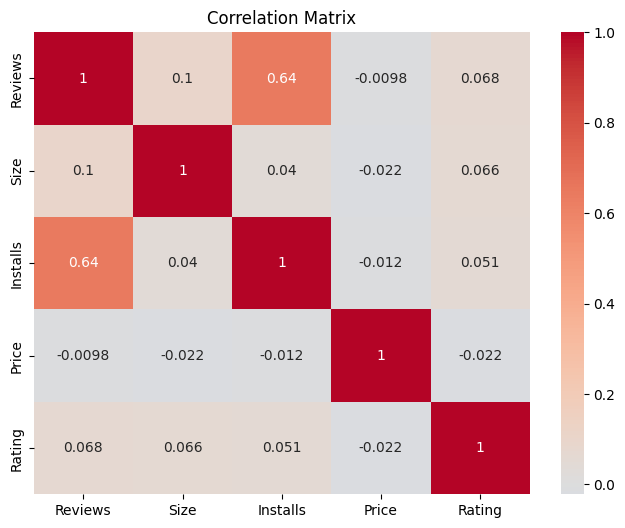

In [50]:

df_correlation = df_regresion[['Reviews','Size','Installs','Price','Rating']]
correlation_matrix = df_correlation.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [51]:
X_new = SelectKBest(f_regression,k=3).fit_transform(x,y)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
pearsonr(df_regresion['Reviews'],df_regresion['Rating'])

PearsonRResult(statistic=0.06813270883720679, pvalue=4.155367872052734e-11)

As we can see, the p-value is close to 0 which suggests that it is unlikely for the observed correlation to be due to chance, implying a statistically significant correlation.

AttributeError: 'JointGrid' object has no attribute 'annotate'

<Figure size 600x300 with 0 Axes>

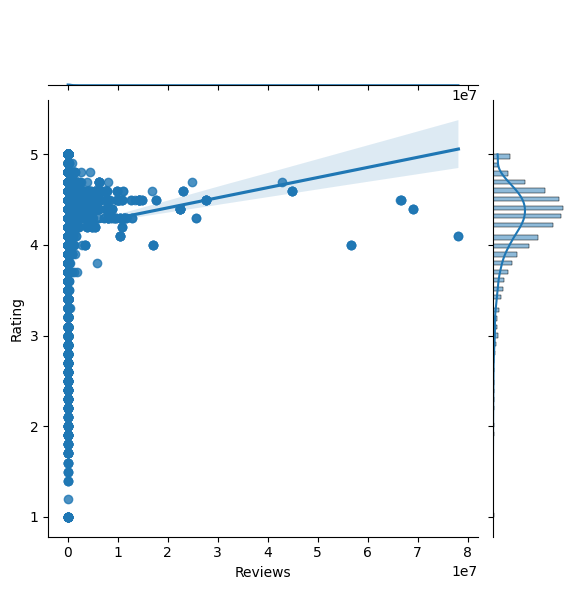

In [53]:
plt.figure(figsize=(6, 3))

correlation_study = sns.jointplot( x = 'Reviews',y = 'Rating', data=df_regresion, kind='reg')
correlation_study.annotate(stats.pearsonr)

correlation_study.fig.suptitle('Correlation graphic (Reviews vs Rating)', y=1.02)

plt.show()

Finally let's compare all p-values and correlation coefs.

In [54]:
result_data = []

for feature in key_features: #I defined key_fetures upstream
    correlation, p_value = pearsonr(df_regresion[feature], df_regresion['Rating'])
    result_data.append({'Features': feature, 'co-relation': correlation, 'P-value': p_value})

result_table = pd.DataFrame(result_data)
# Mostrar la tabla de resultados
print(result_table)

   Features  co-relation       P-value
0   Reviews     0.068133  4.155368e-11
1      Size     0.065855  1.802004e-10
2  Installs     0.051337  6.719095e-07
3     Price    -0.021919  3.395385e-02


Since the feature with less correlation is the Price (and taking into account that the P-value low to 0 in every row suggests that we can trust that the results are not due to chance), we are removing this feature from the model.

In [55]:
df_regresion.drop('Price', axis = 1, inplace = True)
df_regresion.corr()

C:\Users\user\AppData\Local\Temp\ipykernel_20900\928799755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regresion.drop('Price', axis = 1, inplace = True)
C:\Users\user\AppData\Local\Temp\ipykernel_20900\928799755.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_regresion.corr()


,Rating,Reviews,Size,Installs,Year_Last_Updated,Month_Last_Updated
Rating,1.000000,0.068133,0.065855,0.051337,0.137871,0.017234
Reviews,0.068133,1.000000,0.100870,0.641605,0.078321,0.048959
Size,0.065855,0.100870,1.000000,0.040449,0.180164,0.031644
Installs,0.051337,0.641605,0.040449,1.000000,0.092689,0.060282
Year_Last_Updated,0.137871,0.078321,0.180164,0.092689,1.000000,-0.171858
Month_Last_Updated,0.017234,0.048959,0.031644,0.060282,-0.171858,1.000000


### 4) Detecting and eliminating outliers

Outliers:
                                                 App             Category  \
169                       English Persian Dictionary  BOOKS_AND_REFERENCE   
600                         iPair-Meet, Chat, Dating               DATING   
615                                     Awake Dating               DATING   
695                         iPair-Meet, Chat, Dating               DATING   
728    Free intellectual training game application |            EDUCATION   
...                                              ...                  ...   
10783   Modern Counter Terror Attack – Shooting Game                 GAME   
10784                                     Big Hunter                 GAME   
10793                                      Sid Story                 GAME   
10803                   Fatal Raid - No.1 Mobile FPS                 GAME   
10824                                      Cardio-FR              MEDICAL   

       Rating  Reviews  Size  Installs  Type  Price Content Ratin

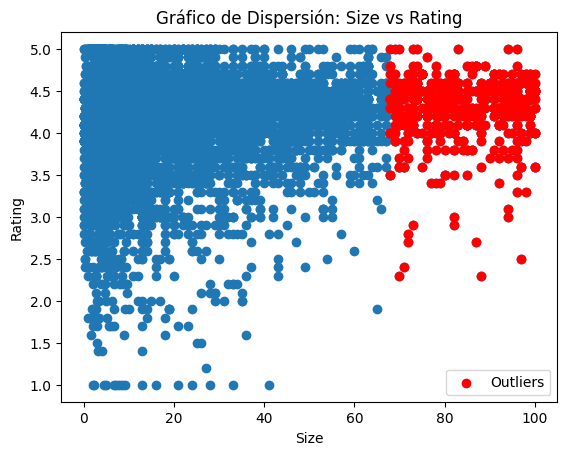

In [56]:

Q1 = df_regresion['Size'].quantile(0.25)
Q3 = df_regresion['Size'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para identificar outliers
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Identificar y mostrar outliers
outliers = df[(df['Size'] < lower_bound) | (df['Size'] > upper_bound)]
print("Outliers:")
print(outliers)

# Crear un gráfico de dispersión
plt.scatter(df_regresion['Size'], df_regresion['Rating'])
plt.title('Gráfico de Dispersión: Size vs Rating')
plt.xlabel('Size')
plt.ylabel('Rating')
#plt.figure(figsize = (6,4))
# Marcar los outliers en el gráfico
plt.scatter(outliers['Size'], outliers['Rating'], color='red', label='Outliers')
plt.legend()

plt.show()

First we are creating a copy of the dataframe just to have a backup in case we make changes we don't want. 
There are multiple ways to determine "what is an outlier". In this case, we are considering them as every value farther than  3 times the standar desviation from the mean.
Then we can:
1) Replace them with the mode
2) Replace them with the mean
3) Replace them with the median
4) Eliminitate those rows
5) Other adjument

Now we are just oging to eliminate them.

In [57]:
df_no_outliers = df_regresion.copy(deep = True)

In [58]:
def remove_outliers_sd(df, feature):
    df_out = pd.DataFrame()
    for key,subdf in df.groupby('Type'):
        m = np.mean(subdf[feature])
        sd = np.std(subdf[feature])
        reduced_df = subdf[(subdf[feature] >= (m - 3*sd)) & (subdf[feature] <= (m + 3*sd))]
        
        df_out=pd.concat([df_out,reduced_df], ignore_index=True)
    return df_out

In [59]:
df_no_outliers = remove_outliers_sd(df_no_outliers, 'Size')
df_no_outliers = remove_outliers_sd(df_no_outliers, 'Installs')
df_no_outliers = remove_outliers_sd(df_no_outliers, 'Reviews')

In [60]:
print(df_regresion.shape)
print(df_no_outliers.shape)

(9360, 14)
(8789, 14)


## 5) Feature Encoding

Since a lof of our data in not numerical, we need to adapt those columns to numbers that can be interpretated by the model.

In [61]:
df_no_outliers.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Year_Last_Updated,Month_Last_Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,2018,1
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,2018,1
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,2018,8
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,2018,6
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,2018,6


Let's start with the Category

In [62]:
mean_per_cat = df_no_outliers.groupby('Category')['Rating'].mean().to_dict()
print(mean_per_cat)

{'ART_AND_DESIGN': 4.377049180327869, 'AUTO_AND_VEHICLES': 4.194366197183099, 'BEAUTY': 4.2785714285714285, 'BOOKS_AND_REFERENCE': 4.357954545454546, 'BUSINESS': 4.120198675496688, 'COMICS': 4.155172413793103, 'COMMUNICATION': 4.133454545454546, 'DATING': 3.9707692307692306, 'EDUCATION': 4.3806666666666665, 'ENTERTAINMENT': 4.116083916083916, 'EVENTS': 4.435555555555555, 'FAMILY': 4.1794730392156865, 'FINANCE': 4.128526645768025, 'FOOD_AND_DRINK': 4.1669724770642205, 'GAME': 4.258683314415437, 'HEALTH_AND_FITNESS': 4.277508650519032, 'HOUSE_AND_HOME': 4.197368421052632, 'LIBRARIES_AND_DEMO': 4.170967741935484, 'LIFESTYLE': 4.104501607717042, 'MAPS_AND_NAVIGATION': 4.04, 'MEDICAL': 4.187861271676301, 'NEWS_AND_MAGAZINES': 4.130493273542601, 'PARENTING': 4.283333333333333, 'PERSONALIZATION': 4.330232558139535, 'PHOTOGRAPHY': 4.181456953642384, 'PRODUCTIVITY': 4.2003003003003005, 'SHOPPING': 4.249333333333333, 'SOCIAL': 4.256896551724138, 'SPORTS': 4.216612377850163, 'TOOLS': 4.0345070422

In [63]:
df_no_outliers['Category'] = df_no_outliers['Category'].map(mean_per_cat)

Unlike Category, Content Rating values actually has an order. Because you now that everyone can go to a 'Everyone' movie, but not to an 'Mature +17' one. So we are going to give them number in term of the amount of people that can go to see them.

In [64]:
dict_contect = {}
print(df_no_outliers['Content Rating'].unique())

['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated']


In [65]:
dict_contect['Unrated'] = 1
dict_contect['Everyone'] = 2
dict_contect['Everyone 10+'] = 3
dict_contect['Teen'] = 4
dict_contect['Mature 17+'] = 5
dict_contect['Adults only 18+'] = 6
print(dict_contect)

{'Unrated': 1, 'Everyone': 2, 'Everyone 10+': 3, 'Teen': 4, 'Mature 17+': 5, 'Adults only 18+': 6}


In [66]:
df_no_outliers['Content Rating'] = df_no_outliers['Content Rating'].map(dict_contect)

In [67]:
df_no_outliers.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Year_Last_Updated,Month_Last_Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.377049,4.1,159,19.0,10000,Free,2,Art & Design,2018-01-07,1.0.0,4.0.3 and up,2018,1
1,Coloring book moana,4.377049,3.9,967,14.0,500000,Free,2,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,2018,1
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.377049,4.7,87510,8.7,5000000,Free,2,Art & Design,2018-08-01,1.2.4,4.0.3 and up,2018,8
3,Sketch - Draw & Paint,4.377049,4.5,215644,25.0,50000000,Free,4,Art & Design,2018-06-08,Varies with device,4.2 and up,2018,6
4,Pixel Draw - Number Art Coloring Book,4.377049,4.3,967,2.8,100000,Free,2,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,2018,6


In [68]:
df_no_outliers['Type'].unique()

array(['Free', 'Paid'], dtype=object)

In [69]:
encoder = LabelEncoder()
df_no_outliers['Type'] = encoder.fit_transform(df_no_outliers['Type'])

Now we are going to drop all the columns that we think that don't matter for the porpurse of the study. Even when 'everything' could be useful, having extra information that could lead the model to an inaccurate conclusion. Therefore, we are eliminating some columns like Genres, that could seem importante, but we are not sure about it.

In [70]:
df_no_outliers.drop(['Genres', 'Last Updated', 'Current Ver', 'Android Ver', 'App'], axis = 1, inplace = True)

In [71]:
df_no_outliers.head()

,Category,Rating,Reviews,Size,Installs,Type,Content Rating,Year_Last_Updated,Month_Last_Updated
0,4.377049,4.1,159,19.0,10000,0,2,2018,1
1,4.377049,3.9,967,14.0,500000,0,2,2018,1
2,4.377049,4.7,87510,8.7,5000000,0,2,2018,8
3,4.377049,4.5,215644,25.0,50000000,0,4,2018,6
4,4.377049,4.3,967,2.8,100000,0,2,2018,6


Finally, we want to check 

## 6) Model Prediction

### 6.1.1) Logistict Regression Model
Since the objective of this file is to preduct using random forecast, we actually want to work with the logistict regresion model. Therefore, we need to change the objective variable from floats to ints.

In [72]:
x = df_no_outliers.drop('Rating', axis= 1)
y = df_no_outliers['Rating'].round().astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 21)

In [73]:
model_logistic = LogisticRegression()
model_logistic.fit(x_train, y_train)
y_pred = model_logistic.predict(x_test)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now we calculate the accuracy and the confusion matrix, the 2 main indicators of the model.

In [74]:
# Calculate Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

# Calculate the Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

Accuracy Score: 0.6939704209328783
Confusion Matrix:
[[   0    0    0    4    0]
 [   0    0    0   33    0]
 [   0    0    0  109    0]
 [   0    0    0 1218    9]
 [   0    0    0  383    2]]


Then we are calculating another indicatores that also can help to understand the values.

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


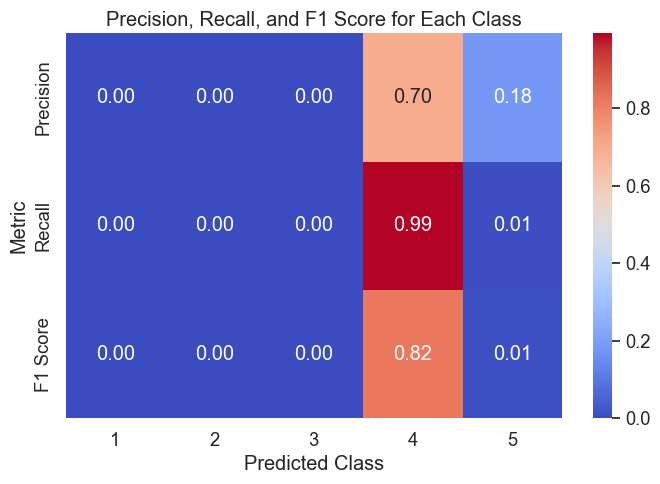

In [75]:

num_classes = len(y.unique())  # Number of possible classes

precision_scores = []
recall_scores = []
f1_scores = []

class_labels = []
class_label = 1

while class_label <= num_classes:
    # Create a mask for the current class
    y_pred_class = (y_pred == class_label)
    y_test_class = (y_test == class_label)

    # Calculate precision, recall, and F1 score for the class
    precision = precision_score(y_test_class, y_pred_class, average='binary')
    recall = recall_score(y_test_class, y_pred_class, average='binary')
    f1 = f1_score(y_test_class, y_pred_class, average='binary')

    # Append the scores to the respective lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    class_labels.append(class_label)
    class_label+=1

# Create a 3x6 matrix to store the results
results_matrix = np.array([precision_scores, recall_scores, f1_scores])

# Print or use the results as needed
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)  # Adjust font size if needed
ax = sns.heatmap(results_matrix, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=class_labels,
                 yticklabels=['Precision', 'Recall', 'F1 Score'])
plt.xlabel('Predicted Class')
plt.ylabel('Metric')
plt.title('Precision, Recall, and F1 Score for Each Class')
plt.show()

WHY DO WE USE 'BINARY? if this is not a binary model? It is because, since we are adding 1 by 1 the values using the "for" loop, what we are doing is evaluating the performance of a classifier for a specific class against the rest. 

Now let's optimize the parameters of the model.

### 6.1.2) Optimizing logistic regresion parameters

In order to find the best parámeters we need to understand what kind of parameters we are going to look for. If we take a close look in the parameters that the logistic regresion uses, there a a lot of them. In this case we are going to focus on 2 of them
1) C: its default value is 1.0 (float), so we are tryng to find the correct magnitude
2) penalty: default value is l2, but we also want to understand if it could be l1, or elasticnet too.

In [76]:
logistic_class = LogisticRegression()
para_grid = {'C': 10.0 ** np.arange(-2, 3), 'penalty': ['none', 'l2'], 'solver': ['lbfgs', 'newton-cg']}

We are going to create the GridSearchCV now to find the better parameters within the options that we decide in the para_grid dictionary.
We are generating only 5 layers of cross validation (cv = 5)
we are using all the CPU cores available.
we are train the focus the best parameters for accuracy

In [77]:
best_logistic_2_= GridSearchCV(estimator = logistic_class, param_grid=para_grid, cv= 5, n_jobs=-1, scoring= 'f1_macro')

In [78]:
best_logistic_2_.fit(x_train, y_train)
print(f'Best estimator: ' + str(best_logistic_2_.best_estimator_))
print(f'Best Parameters: ' + str(best_logistic_2_.best_params_))

Best estimator: LogisticRegression(C=10.0)
Best Parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
optimized_logistic = LogisticRegression(C = 10.0 ,  penalty='l2', solver = 'lbfgs')
optimized_logistic.fit(x_train, y_train)
y_pred_opt_log = optimized_logistic.predict(x_test)
print(accuracy_score(y_test, y_pred_opt_log))

0.6979522184300341


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


By changing the C value from 1 to 10, we can increase the accuracy from 69.4% to 69.8%, which is actually not that big of an improvement. However, we can see the effect of modifying the parameters of the regression.

### 6.2.1) Using Random Forest  to increase the accuracy

In [80]:
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
y_pred_forest = forest.predict(x_test)

# Calculate Accuracy Score
accuracy_forest = accuracy_score(y_test, y_pred_forest)
print("Accuracy Score:", accuracy_forest)

# Calculate the Confusion Matrix
confusion_forest = confusion_matrix(y_test, y_pred_forest)
print("Confusion Matrix:")
print(confusion_forest)

Accuracy Score: 0.7406143344709898
Confusion Matrix:
[[   0    0    0    2    2]
 [   0    1    2   22    8]
 [   0    0    5   95    9]
 [   0    0    8 1164   55]
 [   0    0    1  252  132]]


As we can see, the accuracy score improved using random forest against logistic regression, from 69.4% to 74.1%

### 6.2.2) Optimizing the forest's parameters

In [81]:
forest_class = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(0,2000,10)] #Choose 10 values between  0 and 2000
max_features = ["auto", "sqrt", "log2"] #The default value is auto, so we want to try the other 2 optiones.
max_depth = [int(x) for x in np.linspace(0,2000,10)] #Choose 10 values between  0 and 2000
min_sample_leaf = [1,2,3,4,5,6] #Possible number of samples needed in each leaf core
min_samples_split = [2,5,8,10,12] #Min number of sample that are required
criterio = ['entropy', 'gini'] #Default is gini, but we want to try the other option

In [82]:
para_grid_random = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_sample_leaf,
    'min_samples_split': min_samples_split,
    'criterion': criterio
}

In [85]:
best_forest_2 = RandomizedSearchCV(estimator = forest_class, param_distributions = para_grid_random, n_iter = 20, cv = 4, verbose = 2, random_state = 21, n_jobs = -1)
best_forest_2.fit(x_train, y_train)
print(f'Best estimator: ' + str(best_forest_2.best_estimator_))
print(f'Best Parameters: ' + str(best_forest_2.best_params_))

Fitting 4 folds for each of 20 candidates, totalling 80 fits


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 341, in fit
    self._validate_params()
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", 

Best estimator: RandomForestClassifier(max_depth=1555, min_samples_split=5, n_estimators=666)
Best Parameters: {'n_estimators': 666, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 1555, 'criterion': 'gini'}


In [86]:
optimized_forest = RandomForestClassifier(n_estimators= 666, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 1555, criterion = 'gini')
optimized_forest.fit(x_train, y_train)
y_pred_opt_forest = optimized_forest.predict(x_test)
print(accuracy_score(y_test, y_pred_opt_forest))

0.7417519908987485


By optimizing the parameters, we increased the accuracy from 74.1% to 74.2%. Again, it is not a really huge improvement, but in another cases, this same technic could be really helpful.